# Calibrating probabilities 

### Libs

In [1]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from matplotlib import pyplot as plt

### Generate arbitrary data for classification

In [2]:
data, target = make_classification(n_samples = 10000, n_classes = 2, weights = [1,1], random_state = 24)

data_train, data_test, target_train, target_test = train_test_split(data, target, 
                                                                    train_size = 0.5, random_state = 24)

### Initiate classifiers

In [3]:
clf = {}

clf['lr'] = LogisticRegression(n_jobs = -1).fit(data_train, target_train)

clf['svc'] = SVC(probability = True).fit(data_train, target_train)
clf['svc_calib'] = CalibratedClassifierCV(clf['svc'], method = 'sigmoid', 
                                          cv = 10, n_jobs = -1).fit(data_train, target_train)

clf['rf'] = RandomForestClassifier(n_jobs = -1).fit(data_train, target_train)
clf['rf_calib'] = CalibratedClassifierCV(clf['rf'], method = 'sigmoid', 
                                         cv = 10, n_jobs = -1).fit(data_train, target_train)

clf['nb'] = GaussianNB().fit(data_train, target_train)
clf['nb_calib'] = CalibratedClassifierCV(clf['nb'], method = 'sigmoid', 
                                         cv = 10, n_jobs = -1).fit(data_train, target_train)

### Make predictions

In [4]:
clf['lr_preds'] = clf['lr'].predict_proba(data_test)

clf['svc_preds'] = clf['svc'].predict_proba(data_test)
clf['svc_preds_calib'] = clf['svc_calib'].predict_proba(data_test)

clf['rf_preds'] = clf['rf'].predict_proba(data_test)
clf['rf_preds_calib'] = clf['rf_calib'].predict_proba(data_test)

clf['nb_preds'] = clf['nb'].predict_proba(data_test)
clf['nb_preds_calib'] = clf['nb_calib'].predict_proba(data_test)

### Plot functions

In [5]:
######################### Probability histograms #########################

def plot_hist(preds, preds_cal, model, nbins, log_reg = False) -> None:
    
    """
    Function to plot histograms with predicted probabilities.
    
    Inputs
    -------
    preds: 1D array
           Uncalibrated probabilities of a classifier 
    preds_cal: 1D array
           Calibrated probabilities of a classifier
    model: str
           Name of the model used with classifier
    nbins: int
           Number of bins to use for the histograms
    log_reg: bool
           Default false. Indicates, whether to use Logistic Regression as a model.
           By default, the Logistic Regression has a calibrated probabilities when
           using the predict_proba() method. To avoid ambiguous results, when this
           parameter is set to True, set also preds_cal = None and model = None.
           
    """
    
    if log_reg:
        plt.figure()
        plt.hist(preds[:,0], label = 'Class 0', bins = nbins)
        plt.hist(preds[:,1], label = 'Class 1', bins = nbins)
        plt.legend()
        plt.title('Logistic Regression')
        plt.xlabel('Calibrated probabilities by default')
        plt.ylabel('Counts')
        plt.show()
        
    else:    
        plt.figure()
        plt.hist(preds[:,0], label = 'Class 0', bins = nbins)
        plt.hist(preds[:,1], label = 'Class 1', bins = nbins)
        plt.legend()
        plt.title(f'{model}')
        plt.xlabel('Uncalibrated probabilities')
        plt.ylabel('Counts')
        plt.show()

        plt.figure()
        plt.hist(preds_cal[:,0], label = 'Class 0', bins = nbins)
        plt.hist(preds_cal[:,1], label = 'Class 1', bins = nbins)
        plt.legend()
        plt.title(f'{model}')
        plt.xlabel('Calibrated probabilities')
        plt.ylabel('Counts')
        plt.show()
        
########################################## Reliability diagrams ##############################################
def plot_reliability(target, preds, preds_cal, model, nbins, normalized_hist = True, log_reg = True) -> None:
    
    """
    Function to plot the reliability diagram.
    
    Inputs
    -------
    target: 1D array
           Test data to predict
    preds: 1D array
           Uncalibrated probabilities of a classifier 
    preds_cal: 1D array
           Calibrated probabilities of a classifier
    model: str
           Name of the model used with classifier
    nbins: int
           Number of bins to use for the histograms
    normalized_hist: bool
           Default true. Indicates, whether to use histogram normalization for binning, 
           when calibration_curve function is called. The latter uses as returns
           fop - fraction of positives and mpv - mean predicted values.
    log_reg: bool
           Default false. Indicates, whether to use Logistic Regression as a model.
           By default, the Logistic Regression has a calibrated probabilities when
           using the predict_proba() method. To avoid ambiguous results, when this
           parameter is set to True, set also preds_cal = None and model = None.
    """
    
    if log_reg:
        fop, mpv = calibration_curve(target_test, preds[:,1], n_bins = nbins, normalize = normalized_hist)
        plt.figure()
        plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
        plt.plot(mpv, fop, marker = '.', label = 'Logistic Regression - Calibrated by default')
        plt.legend()
        plt.title('Reliability Diagram')
        plt.xlabel('Mean predicted probability for class 1')
        plt.ylabel('Franction of positives for class 1')
        plt.show()
   
    else:
        fop, mpv = calibration_curve(target_test, preds[:,1], n_bins = nbins, normalize = normalized_hist)
        fop_cal, mpv_cal = calibration_curve(target_test, preds_cal[:,1], n_bins = nbins, normalize = normalized_hist)
        plt.figure()
        plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfect Calibration')
        plt.plot(mpv, fop, marker = '.', label = f'{model} not calibrated')
        plt.plot(mpv_cal, fop_cal, marker = '.', label = f'{model} calibrated')
        plt.legend()
        plt.title('Reliability Diagram')
        plt.xlabel('Mean predicted probability for class 1')
        plt.ylabel('Franction of positives for class 1')
        plt.show()

### Plots

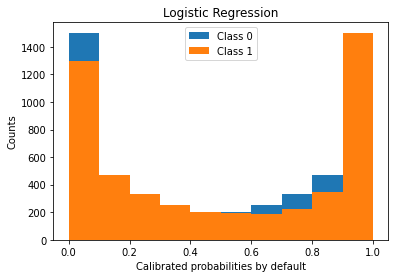

/Users/ddi/python_venv/cnn/cnn/cnn-venv/lib/python3.10/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


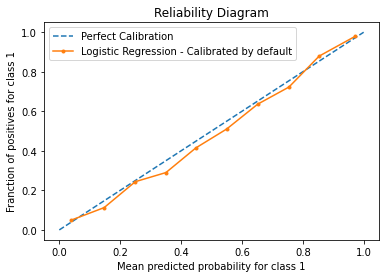

In [6]:
plot_hist(preds = clf['lr_preds'], preds_cal = None, model = None, nbins = 10, log_reg = True)

plot_reliability(target_test, clf['lr_preds'], preds_cal = None, model = None, nbins = 10,
                 normalized_hist = True, log_reg = True)

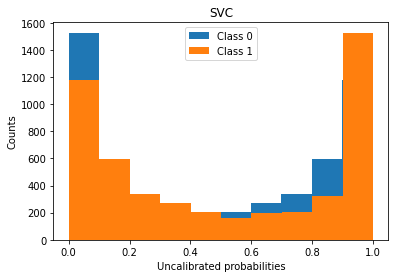

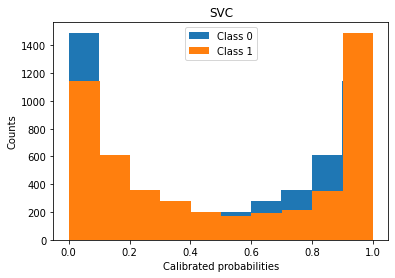

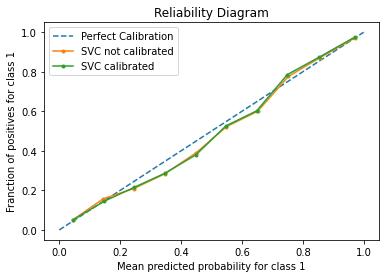

In [7]:
plot_hist(preds = clf['svc_preds'], preds_cal = clf['svc_preds_calib'], model = 'SVC', nbins = 10, log_reg = False)

plot_reliability(target_test, clf['svc_preds'], preds_cal = clf['svc_preds_calib'], model = 'SVC', nbins = 10,
                 normalized_hist = True, log_reg = False)

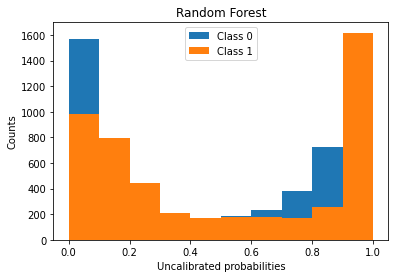

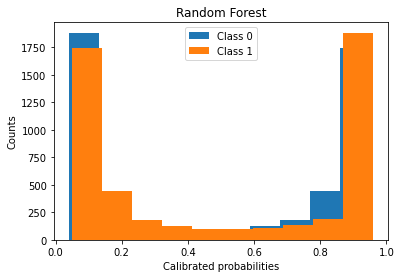

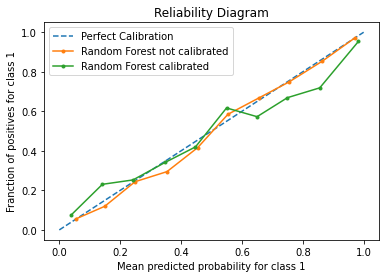

In [8]:
plot_hist(preds = clf['rf_preds'], preds_cal = clf['rf_preds_calib'], model = 'Random Forest', nbins = 10, log_reg = False)

plot_reliability(target_test, clf['rf_preds'], preds_cal = clf['rf_preds_calib'], model = 'Random Forest', nbins = 10,
                 normalized_hist = True, log_reg = False)

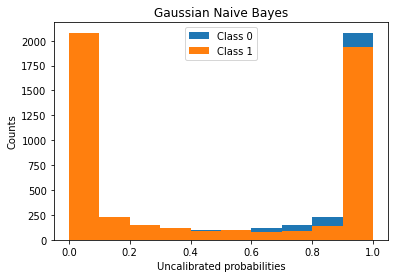

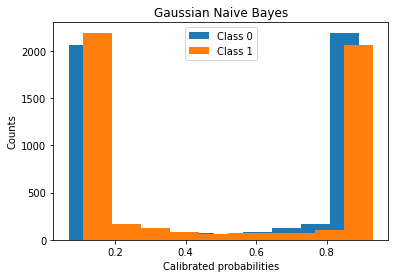

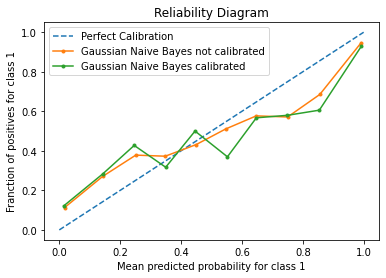

In [9]:
plot_hist(preds = clf['nb_preds'], preds_cal = clf['nb_preds_calib'], model = 'Gaussian Naive Bayes', nbins = 10, log_reg = False)

plot_reliability(target_test, clf['nb_preds'], preds_cal = clf['nb_preds_calib'], model = 'Gaussian Naive Bayes', nbins = 10,
                 normalized_hist = True, log_reg = False)